### Read in data

In [131]:
import psycopg2
import pandas as pd
import numpy as np
import time
from datetime import timedelta, datetime
from matplotlib import pyplot as plt
from collections import defaultdict
import random

In [2]:
con = psycopg2.connect(user = "postgres",
                       password = "",
                       host = "127.0.0.1",
                       port = "5432",
                       database = "adj_noun_pairs")

try:
    cursor = con.cursor();
except (Exception, psycopg2.Error) as error:
    print("Error in Connection",error)

In [3]:
cursor.execute("SELECT * FROM final_pairs")
all_pairs = cursor.fetchall() 

In [4]:
all_pairs[0]

('eelmine', 'aasta', 53250)

In [ ]:
# nouns = list(set([pair[1] for pair in all_pairs]))
# adjectives = list(set([pair[0] for pair in all_pairs]))

In [5]:
dup_nouns = [pair[1] for pair in all_pairs]
# Easy naive for-loop to keep order so results wouldn't change each time
nouns = []
for noun in dup_nouns:
    if noun not in nouns:
        nouns.append(noun)

In [6]:
dup_adjectives = [pair[0] for pair in all_pairs]
adjectives = []
for adj in dup_adjectives:
    if adj not in adjectives:
        adjectives.append(adj)

In [7]:
data = pd.DataFrame(None, index=nouns, columns=adjectives)
data.head()

,eelmine,järgmine,viimane,käesolev,kogu,kohalik,suur,pikk,juriidiline,tulev,...,realiseeritav,valgustatav,vajuv,väikesekasvuline,väikeseformaadiline,õlirikas,õigusetu,oletuslik,raugematu,raudteeäärne
aasta,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
aeg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
määrus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
omavalitsus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
osa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
for tup in all_pairs:
    data.loc[tup[1], tup[0]] = tup[2]

In [9]:
data = data.fillna(0)
data.head()

,eelmine,järgmine,viimane,käesolev,kogu,kohalik,suur,pikk,juriidiline,tulev,...,realiseeritav,valgustatav,vajuv,väikesekasvuline,väikeseformaadiline,õlirikas,õigusetu,oletuslik,raugematu,raudteeäärne
aasta,53250,38107,24410,11753,1115,40,114,1562,0,12634,...,0,0,0,0,0,0,0,0,0,0
aeg,75,65,27915,1227,24997,1373,194,14913,0,18,...,0,0,0,0,0,0,0,0,0,0
määrus,16,110,17,27514,30,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
omavalitsus,30,67,44,0,31,24261,84,0,12,0,...,0,0,0,0,0,0,0,0,0,0
osa,201,436,918,118,51,10,22165,25,0,17,...,0,0,0,0,0,0,0,0,0,0


In [10]:
data.shape

(14590, 7442)

### LDA

In [11]:
from sklearn.decomposition import LatentDirichletAllocation

In [12]:
lda = LatentDirichletAllocation(n_components=500, random_state=0)

In [13]:
start = datetime.now()
print(str(timedelta(seconds=time.time()+7200)).split(", ")[1])
results = lda.fit_transform(data)
print(str(timedelta(seconds=time.time()+7200)).split(", ")[1])
print(datetime.now()-start)

22:44:23.664739
22:56:28.117120
0:12:04.452382


In [14]:
topics = {}
for i in range(500):
    topics[i] = []

for idx, prob in enumerate(results):
    topics[np.argmax(prob)].append(data.index[idx])

### Results

In [33]:
adjs_in_topics = pd.DataFrame(lda.components_, columns=data.columns)

In [34]:
adjs_in_topics.head()

,eelmine,järgmine,viimane,käesolev,kogu,kohalik,suur,pikk,juriidiline,tulev,...,realiseeritav,valgustatav,vajuv,väikesekasvuline,väikeseformaadiline,õlirikas,õigusetu,oletuslik,raugematu,raudteeäärne
0,0.002000,0.002000,0.002000,0.002000,0.002000,0.002000,0.002000,0.002000,0.002,18.173336,...,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002
1,10.008601,4.264048,5.633426,0.002004,0.002000,0.043676,0.002000,2.948849,0.002,0.002000,...,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002
2,0.002000,67.371256,0.002000,0.002000,31.516767,0.002000,10.405239,0.002000,0.002,0.002000,...,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002
3,0.002000,0.002000,0.002000,0.002000,0.002000,0.002000,0.002000,0.002000,0.002,0.002000,...,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002
4,0.002000,0.002000,9.037945,0.002000,0.413545,0.002000,55.952026,0.002000,0.002,0.002000,...,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002


#### Month topics

In [15]:
kuud = ['jaanuar', 'veebruar', 'märts', 'aprill', 'mai', 'juuni', 'juuli', 'august', 'september', 'oktoober', 'november', 'detsember']
idx = []

for kuu in kuud:
    for topic, words in topics.items():
        if kuu in words:
            idx.append(topic)
            continue

In [16]:
idx

[311, 311, 311, 311, 281, 487, 499, 412, 98, 98, 98, 98]

In [39]:
for i in set(idx):
    print(f"topic {i}, with {idx.count(i)} month(s)")
    print(topics[i])
    print("Most common adjectives in topic:")
    print(adjs_in_topics.loc[i][adjs_in_topics.loc[i] > 10].sort_values(ascending=False).head())
    print("----------------------------")

topic 98, with 4 month(s)
['reede', 'nädalavahetus', 'laupäev', 'pühapäev', 'nädalalõpp', 'aastavahetus', 'detsember', 'oktoober', 'september', 'november', 'täke', 'manalatee', 'kütteperiood', 'kesknädal', 'õng', 'täissaal']
Most common adjectives in topic:
läinud      11450.466384
eelmine      4492.928065
eelolev      3312.483890
järgmine      712.923183
tulev         422.942508
Name: 98, dtype: float64
----------------------------
topic 487, with 1 month(s)
['ilm', 'suvepäev', 'puder', 'kasvukoht', 'mähis', 'juuni']
Most common adjectives in topic:
ilus       2227.053373
soe        1939.531957
külm       1672.019050
vihmane    1388.159375
kuum        986.957659
Name: 487, dtype: float64
----------------------------
topic 499, with 1 month(s)
['grupp', 'rühm', 'võistkond', 'alagrupp', 'pirukas', 'pann', 'vann', 'triikraud', 'pliit', 'ekskursioon', 'võileib', 'juuli', 'kakao', 'rannaliiv', 'puljong', 'föön', 'keris', 'armulugu', 'jalavann', 'rannailm', 'kriminaalkolleegium', 'demineeri

#### Days topics

In [18]:
days = ['esmaspäev', 'teisipäev', 'kolmapäev', 'neljapäev', 'reede', 'laupäev', 'pühapäev']
idx2 = []

for day in days:
    for topic, words in topics.items():
        if day in words:
            idx2.append(topic)
            continue

In [19]:
idx2

[299, 299, 299, 299, 98, 98, 98]

In [40]:
for i in set(idx2):
    print(i, ":", topics[i])
    print("Most common adjectives in topic:")
    print(adjs_in_topics.loc[i][adjs_in_topics.loc[i] > 10].sort_values(ascending=False).head())
    print("----------------------------")

98 : ['reede', 'nädalavahetus', 'laupäev', 'pühapäev', 'nädalalõpp', 'aastavahetus', 'detsember', 'oktoober', 'september', 'november', 'täke', 'manalatee', 'kütteperiood', 'kesknädal', 'õng', 'täissaal']
Most common adjectives in topic:
läinud      11450.466384
eelmine      4492.928065
eelolev      3312.483890
järgmine      712.923183
tulev         422.942508
Name: 98, dtype: float64
----------------------------
299 : ['aasta', 'nädal', 'hooaeg', 'suvi', 'sajand', 'õhtu', 'sügis', 'neljapäev', 'koosseis', 'kevad', 'kolmapäev', 'tali', 'õppeaasta', 'esmaspäev', 'teisipäev', 'lugemine', 'majandusaasta', 'eelarveaasta', 'olümpia', 'kalendriaasta', 'postitus', 'post', 'tsükkel', 'sajandivahetus', 'loendus', 'valitsusaeg', 'valiktsükkel', 'valitsemisaeg', 'alapeatükk', 'maksustamisperiood', 'kalandusaasta', 'aruandeaasta', 'rahandusaasta', 'kvoodiaasta', 'EM-tsükkel', 'erastamisvoor', 'MM-tsükkel', 'kümnendivahetus', 'sajandilõpp']
Most common adjectives in topic:
eelmine     101229.421141


#### Artistic professions

In [21]:
jobs = ['laulja', 'näitleja', 'kunstnik', 'tantsija', 'artist']
idx3 = []

for job in jobs:
    for topic, words in topics.items():
        if job in words:
            idx3.append(topic)
            continue

In [22]:
idx3

[378, 378, 378, 330, 378]

In [41]:
for i in set(idx3):
    print(i, ":", topics[i])
    print("Most common adjectives in topic:")
    print(adjs_in_topics.loc[i][adjs_in_topics.loc[i] > 10].sort_values(ascending=False).head())
    print("----------------------------")

378 : ['näitleja', 'kunstnik', 'laulja', 'muusik', 'mängija', 'teadlane', 'kirjanik', 'bänd', 'lavastaja', 'ajakirjanik', 'helilooja', 'sportlane', 'disainer', 'arhitekt', 'pianist', 'lauljatar', 'dirigent', 'kaasmaalane', 'ansambel', 'luuletaja', 'näitlejanna', 'sõitja', 'jalgpallur', 'režissöör', 'suusataja', 'artist', 'solist', 'väravavaht', 'korvpallur', 'rezhissöör', 'moelooja', 'inglane', 'sakslane', 'pallur', 'tenor', 'kohtutäitur', 'viiuldaja', 'poeet', 'prohvet', 'looja', 'fotograaf', 'tagamees', 'rootslane', 'näitlejatar', 'eelkäija', 'tõlkija', 'filosoof', 'prantslane', 'lauljanna', 'kultuuritegelane', 'hispaanlane', 'maalikunstnik', 'kirurg', 'meistersportlane', 'itaallane', 'sopran', 'skulptor', 'detektiiv', 'näitekirjanik', 'ameeriklanna', 'tohter', 'filminäitleja', 'veteran', 'brasiillane', 'essee', 'koomik', 'literaat', 'semiootik', 'välikomandör', 'rockansambel', 'tšehh', 'meresõitja', 'tõlk', 'kunstitegelane', 'poolakas', 'füüsik', 'mannekeen', 'naiskirjanik', 'kitarr

#### Sports

In [25]:
spordialad = ['jalgpall', 'korvpall', 'pesapall', 'võrkpall', 'golf', 'tennis']
idx4 = []

for spordiala in spordialad:
    for topic, words in topics.items():
        if spordiala in words:
            idx4.append(topic)
            continue

In [26]:
idx4

[97, 66, 493, 95, 66]

In [29]:
for i in set(idx4):
    print(i, ":", topics[i])
    print("----------------------------")

97 : ['tippkohtumine', 'kurss', 'jalgpall', 'aktsionär', 'finaalturniir', 'uluk', 'juunior', 'maailmameistrivõistlus', 'tollivormistus', 'kordusmäng', 'kergejõustik', 'finaalseeria', 'atlant', 'teener', 'jäähoki', 'MM-valikmäng', 'liitumisläbirääkimised', 'valvur', 'jünger', 'parteisõdur', 'poolfinaalseeria', 'andmekogu', 'EM-finaalturniir', 'maailmanäitus', 'universiaad', 'EM-võistlus', 'alam', 'lõppkontsert', 'murdmaasuusatamine', 'parteikongress', 'läänemeremaa', 'aednik', 'europarlament', 'lõppvõistlus', 'märgijada', 'EM-valikturniir', 'veerandfinaalseeria', 'ühinemisläbirääkimised', 'umbusaldushääletus', 'inspekteerimine', 'lühirada', 'korduskohtumine', 'MM-turniir', 'sõudmine', 'galaõhtu', 'sulane', 'rannavõrkpall', 'finaalvõistlus', 'teabepäev', 'ujumine']
----------------------------
66 : ['tänu', 'tõenäosus', 'saal', 'vahe', 'slämm', 'raskus', 'ekraan', 'lootus', 'koormus', 'rõõm', 'risk', 'silm', 'täht', 'mure', 'pauk', 'lava', 'segadus', 'armastus', 'vaev', 'au', 'puudus', '

#### Abstract ?

In [30]:
abstract = ['ilu', 'inimõigus', 'vabadus']
idx5 = []

for a in abstract:
    for topic, words in topics.items():
        if a in words:
            idx5.append(topic)
            continue

In [31]:
idx5

[74, 377, 359]

In [32]:
for i in set(idx5):
    print(i, ":", topics[i])
    print("----------------------------")

377 : ['takistus', 'kahtlusalune', 'verejooks', 'tegevusala', 'inimõigus', 'märksõna', 'sissetulekuallikas', 'toetaja', 'tuluallikas', 'rahastaja', 'asjaajamiskeel', 'kaubanduspartner', 'mina', 'trump', 'vaatamisväärsus', 'tõmbenumber', 'töökorraldus', 'põlemine', 'tegevusvaldkond', 'eestvedaja', 'ekspordiartikkel', 'töövahend', 'motivatsioon', 'põhjustaja', 'opositsioonipartei', 'tugipunkt', 'ohustaja', 'komistuskivi', 'elatusallikas', 'surmapõhjus', 'pretendent', 'eksporditurg', 'uurimisvaldkond', 'valimislubadus', 'kõneaine', 'opositsioonijõud', 'tasuvuslävi', 'partnerriik', 'jututeema', 'vastuargument', 'sihtriik', 'kompensatsioonitoode', 'arutlusteema', 'tõukejõud', 'vastuväide', 'vaat', 'valupunkt', 'infoallikas', 'tellija', 'huviobjekt', 'ekspordipartner', 'tegevussuund', 'tüliõun', 'tiitlipretendent', 'vaidlusküsimus', 'kullasoosik', 'tüliküsimus', 'puhastumine', 'medalilootus', 'eksportturg', 'esikohapretendent', 'kaubaartikkel', 'skooritegija', 'rahastamis', 'alustala', 'kasv

### Adjectives in topics

#### Colours

In [42]:
colours = ['valge', 'kollane', 'oranž', 'roosa', 'punane', 'pruun', 'roheline', 'sinine', 'lilla', 'hall', 'must']

In [43]:
adjs_in_topics[colours]

,valge,kollane,oranž,roosa,punane,pruun,roheline,sinine,lilla,hall,must
0,0.002000,0.002000,0.002000,0.002000,0.002000,0.002,0.002,0.002000,0.002,0.002,0.002
1,0.002000,0.002000,0.002000,0.002000,0.002000,0.002,0.002,0.002000,0.002,0.002,0.002
2,28.901482,11.031886,0.002000,0.002000,19.082562,0.002,0.002,0.002000,0.002,0.002,0.002
3,0.002000,0.002000,0.002000,0.002000,0.002000,0.002,0.002,0.002000,0.002,0.002,0.002
4,0.002000,0.002000,0.002000,0.002000,0.002000,0.002,0.002,0.002000,0.002,0.002,0.002
...,...,...,...,...,...,...,...,...,...,...,...
495,903.835248,9.092570,1.463884,826.739958,1594.533344,0.002,0.002,0.003077,24.002,0.002,0.002
496,0.002000,0.002000,0.002000,0.002000,0.002000,0.002,0.002,0.002000,0.002,0.002,0.002
497,0.002000,0.002000,0.002000,0.002000,0.002000,0.002,0.002,0.002000,0.002,0.002,0.002
498,0.002000,0.002000,0.002000,0.002000,0.002000,0.002,0.002,0.002000,0.002,0.002,0.002


In [47]:
for colour in colours:
    print(f"Värv '{colour}'")
    col_topics = adjs_in_topics[colour][adjs_in_topics[colour] > 0.002].sort_values(ascending=False)
    print(f"Number of topics with probability > 0.002 (default) is {len(col_topics)}")
    print(col_topics)
    print("-------------------------")

Värv 'valge'
Number of topics with probability > 0.002 (default) is 50
301    20284.361979
495      903.835248
92       473.002000
419      378.039403
11       297.522789
348      124.407198
186      103.177280
484       86.204250
144       66.778338
481       62.287594
455       59.439476
51        55.578511
366       47.851750
270       46.269974
255       39.507324
490       36.021581
272       34.002000
343       29.613835
2         28.901482
30        24.987718
372       23.067407
152       15.973656
148       15.901999
491       13.983126
68        11.944672
47        11.888624
179       11.010638
269        7.782792
352        5.422127
488        4.008594
423        1.216304
357        0.989544
88         0.935862
417        0.689665
431        0.675459
48         0.658079
238        0.575787
324        0.489996
322        0.475322
16         0.324426
336        0.148079
108        0.072384
39         0.025090
104        0.020290
424        0.018218
40         0.004127
219      

In [52]:
colours_topics = defaultdict(list)

for colour in colours:
    col_topics = adjs_in_topics[colour][adjs_in_topics[colour] > 0.002].sort_values(ascending=False).head(3)
    for index in col_topics.index:
        colours_topics[index].append(colour)

In [53]:
colours_topics

defaultdict(list,
            {301: ['valge'],
             495: ['valge', 'roosa', 'punane', 'lilla'],
             92: ['valge'],
             379: ['kollane'],
             372: ['kollane', 'oranž', 'punane', 'sinine'],
             488: ['kollane'],
             55: ['oranž'],
             336: ['oranž', 'roosa', 'pruun', 'lilla'],
             484: ['roosa'],
             431: ['punane'],
             38: ['pruun'],
             88: ['pruun', 'hall'],
             196: ['roheline'],
             455: ['roheline'],
             201: ['roheline'],
             417: ['sinine'],
             491: ['sinine'],
             270: ['lilla'],
             384: ['hall'],
             419: ['hall'],
             144: ['must'],
             170: ['must'],
             119: ['must']})

In [75]:
print(topics[495])

['vein', 'õis', 'panter', 'vihik', 'huul', 'elevant', 'kaustik', 'krants', 'vihikuleht', 'flanellsärk']


In [76]:
print(topics[372])

['lipp', 'vilkur', 'plekk', 'lint', 'tunked', 'teksased', 'trikoloor', 'lipuke', 'ingel', 'kilesuss', 'värvikombinatsioon', 'pastakas', 'riigilipp', 'soojustus', 'pekk', 'meistrisärk', 'rahvuslipp', 'dressipluus', 'käoking']


In [77]:
print(topics[336])

['värv', 'toon', 'meresõit', 'värvitoon', 'tegumood', 'rahvusrind', 'vahendamine', 'riigimonopol', 'juurdehindlus', 'retuusid', 'esitusviis']


In [114]:
for colour in colours:
    print(f"Värv '{colour}'")
    col_topics = adjs_in_topics[colour][adjs_in_topics[colour] > 0.002].sort_values(ascending=False)
    top_1 = col_topics.index[0]
    print(f"Topic with highest probability is {top_1}:")
    print(topics[top_1])
    print("-------------------------")

Värv 'valge'
Topic with highest probability is 301:
['suhkur', 'särk', 'pulber', 'kittel', 'viin', 'laik', 'lina', 'pluus', 'sein', 'triip', 'kinnas', 'malend', 'vares', 'hiinlane', 'šokolaad', 'rass', 'jõulud', 'paberileht', 'kepp', 'farmer', 'tuvi', 'triiksärk', 'kaubik', 'marmor', 'neeger', 'T-särk', 'krae', 'rüü', 'luik', 'põll', 'fosfor', 'sukkpüksid', 'peakapsas', 'kurg', 'kuup', 'hõlst', 'pruutkleit', 'räppar', 'ratsu', 'ülemvõim', 'liilia', 'plastmass', 'laudlina', 'rant', 'puri', 'kääbus', 'põlvik', 'pärslane', 'loor', 'sammas', 'ollus', 'ürp', 'hobu', 'kääbustäht', 'vatt', 'botas', 'taskurätik', 'mikrobuss', 'vesiroos', 'aknaraam', 'vererakk', 'vööt', 'orbit', 'ristikhein', 'kirjapaber', 'muskus', 'uss', 'invertsuhkur', 'tutt', 'mesikas', 'tiibklaver', 'küülik', 'siid', 'pojeng', 'plasttool', 'majavein', 'veiniäädikas', 'taskurätt', 'gospel', 'linik', 'pearätt']
-------------------------
Värv 'kollane'
Topic with highest probability is 379:
['kaart', 'õpik', 'liidrisärk', 'ka

#### Positive adjectives about intelligence

In [65]:
adjs = ['tark', 'intelligentne', 'taibukas', 'arukas']

In [66]:
adjs_topics = defaultdict(list)

for adj in adjs:
    adj_topics = adjs_in_topics[adj][adjs_in_topics[adj] > 0.002].sort_values(ascending=False).head(3)
    for index in adj_topics.index:
        adjs_topics[index].append(adj)

In [67]:
adjs_topics

defaultdict(list,
            {92: ['tark', 'intelligentne', 'taibukas', 'arukas'],
             11: ['tark', 'intelligentne'],
             40: ['tark', 'arukas'],
             416: ['intelligentne'],
             114: ['arukas']})

In [68]:
for adj in adjs:
    print(f"Omadussõna '{adj}'")
    adj_topics = adjs_in_topics[adj][adjs_in_topics[adj] > 0.002].sort_values(ascending=False)
    print(f"Number of topics with probability > 0.002 (default) is {len(adj_topics)}")
    print(adj_topics.head(3))
    print("-------------------------")

Omadussõna 'tark'
Number of topics with probability > 0.002 (default) is 44
92    908.965992
11    637.804527
40    583.108195
Name: tark, dtype: float64
-------------------------
Omadussõna 'intelligentne'
Number of topics with probability > 0.002 (default) is 19
92     409.931101
11      70.002000
416     51.923391
Name: intelligentne, dtype: float64
-------------------------
Omadussõna 'taibukas'
Number of topics with probability > 0.002 (default) is 1
92    15.002
Name: taibukas, dtype: float64
-------------------------
Omadussõna 'arukas'
Number of topics with probability > 0.002 (default) is 21
92     360.002000
40      82.042696
114     74.166483
Name: arukas, dtype: float64
-------------------------


In [69]:
topics[92]

['inimene']

In [73]:
print(topics[40])

['jutt', 'noorkuu', 'kysimus', 'lits', 'raffas', 'pallikaotus', 'onn', 'põhjamaa', 'veesõiduk', 'ple', 'polex', 'jõulurahu']


In [72]:
adjs_in_topics.loc[40][adjs_in_topics.loc[40] > 10].sort_values(ascending=False)

loll               940.794537
rumal              740.522653
tark               583.108195
olnud              367.987194
segane             273.714130
                      ...    
igapäevane          10.459093
meeldiv             10.067713
vastutustundetu     10.002000
umbmäärane          10.002000
pubekas             10.002000
Name: 40, Length: 150, dtype: float64

### Information about topics

#### Topic lengths

In [115]:
for i in range(500):
    print(f"Topic {i} has {len(topics[i])} words")

Topic 0 has 8 words
Topic 1 has 9 words
Topic 2 has 9 words
Topic 3 has 8 words
Topic 4 has 53 words
Topic 5 has 14 words
Topic 6 has 23 words
Topic 7 has 5 words
Topic 8 has 14 words
Topic 9 has 28 words
Topic 10 has 18 words
Topic 11 has 1 words
Topic 12 has 18 words
Topic 13 has 9 words
Topic 14 has 38 words
Topic 15 has 5 words
Topic 16 has 5 words
Topic 17 has 17 words
Topic 18 has 8 words
Topic 19 has 3 words
Topic 20 has 31 words
Topic 21 has 1 words
Topic 22 has 7 words
Topic 23 has 115 words
Topic 24 has 40 words
Topic 25 has 11 words
Topic 26 has 7 words
Topic 27 has 28 words
Topic 28 has 44 words
Topic 29 has 35 words
Topic 30 has 4 words
Topic 31 has 15 words
Topic 32 has 3 words
Topic 33 has 5 words
Topic 34 has 23 words
Topic 35 has 27 words
Topic 36 has 4 words
Topic 37 has 3 words
Topic 38 has 14 words
Topic 39 has 13 words
Topic 40 has 12 words
Topic 41 has 171 words
Topic 42 has 19 words
Topic 43 has 68 words
Topic 44 has 9 words
Topic 45 has 10 words
Topic 46 has 4 w

In [116]:
long_topics = []
short_topics = []

for i in range(500):
    topic_len = len(topics[i])
    if topic_len >= 100:
        long_topics.append(i)
    if topic_len <= 5:
        short_topics.append(i)

In [117]:
print(f"{len(long_topics)} topics have 100 words or more")
print(f"{len(short_topics)} topics have 5 words or less")

20 topics have 100 words or more
95 topics have 5 words or less


In [118]:
for i in short_topics:
    print(topics[i])
    print("-------------------------------------")

['abimees', 'aminohape', 'reprodutseerimine', 'kõnesolev', 'kunstiväärtus']
-------------------------------------
['mees']
-------------------------------------
['rahastamine', 'finantseerimine', 'keeleoskus', 'rahasüsteem', 'paaripanek']
-------------------------------------
['abielu', 'paar', 'kooselu', 'leil', 'kütuseeksport']
-------------------------------------
['organisatsioon', 'näitus', 'keskkonnaorganisatsioon']
-------------------------------------
['otsus']
-------------------------------------
['pilt', 'foto', 'vaatepilt', 'maailmapilt']
-------------------------------------
['karistus', 'tähtaeg', 'eemaldamine']
-------------------------------------
['nimetus', 'tiitel', 'hilisõhtu', 'sentents', 'redestilleerimine']
-------------------------------------
['rand', 'brutomarginaal', 'turuplats', 'raviaparaat']
-------------------------------------
['olukord', 'olu', 'situatsioon']
-------------------------------------
['kaitse', 'kõneviis', 'vrakk', 'tuumaallveelaev']
------

In [119]:
topic_lens = []

for i in range(500):
    topic_lens.append((i, len(topics[i])))

In [122]:
topics_sorted_by_len = sorted(topic_lens, key=lambda x: x[1], reverse=True)

In [124]:
topics_sorted_by_len[:10]

[(95, 1251),
 (66, 926),
 (312, 425),
 (332, 399),
 (85, 375),
 (452, 246),
 (258, 204),
 (61, 192),
 (275, 173),
 (41, 171)]

#### Pair exploration in longest topics

In [128]:
adjs_in_topics.loc[95].sort_values(ascending=False).head()

uus         229362.022903
praegune       754.365635
senine          90.433075
valmis          78.872647
olnud           52.699986
Name: 95, dtype: float64

In [132]:
random_95 = random.sample(topics[95], 10)

In [134]:
for word in random_95:
    cursor.execute(f"SELECT * FROM final_pairs WHERE noun = '{word}'")
    print(cursor.fetchall())
    print("---------------------")

[('uus', 'veoajam', 11)]
---------------------
[('uus', 'jõukeskus', 10)]
---------------------
[('uus', 'ärinimi', 89)]
---------------------
[('uus', 'kindlustusseadus', 14), ('riiklik', 'kindlustusseadus', 12), ('kehtiv', 'kindlustusseadus', 11)]
---------------------
[('uus', 'tööturuteenus', 37)]
---------------------
[('uus', 'põlvkond', 2197), ('järgmine', 'põlvkond', 589), ('noor', 'põlvkond', 394), ('eelmine', 'põlvkond', 283), ('terve', 'põlvkond', 259), ('tulevane', 'põlvkond', 209), ('eri', 'põlvkond', 176), ('praegune', 'põlvkond', 175), ('kasvav', 'põlvkond', 136), ('erinev', 'põlvkond', 112), ('järeltulev', 'põlvkond', 101), ('keskmine', 'põlvkond', 94), ('järgnev', 'põlvkond', 87), ('viimane', 'põlvkond', 64), ('sõjajärgne', 'põlvkond', 58), ('vana', 'põlvkond', 55), ('pealekasvav', 'põlvkond', 48), ('eelnev', 'põlvkond', 40), ('sirguv', 'põlvkond', 36), ('tänane', 'põlvkond', 36), ('keskealine', 'põlvkond', 31), ('tulnud', 'põlvkond', 25), ('kogu', 'põlvkond', 25), ('s

In [129]:
adjs_in_topics.loc[66].sort_values(ascending=False).head()

suur            192242.233981
siiras             138.068997
väike              125.917435
puutetundlik       104.002000
hiiglaslik          88.594226
Name: 66, dtype: float64

In [135]:
random_66 = random.sample(topics[66], 10)

In [136]:
for word in random_66:
    cursor.execute(f"SELECT * FROM final_pairs WHERE noun = '{word}'")
    print(cursor.fetchall())
    print("---------------------")

[('suur', 'lõhe', 102), ('vaheline', 'lõhe', 92), ('sügav', 'lõhe', 63), ('süvenev', 'lõhe', 31), ('digitaalne', 'lõhe', 29), ('sotsiaalne', 'lõhe', 27), ('looduslik', 'lõhe', 18), ('kasvav', 'lõhe', 17), ('värske', 'lõhe', 17), ('suurenev', 'lõhe', 15), ('armistumata', 'lõhe', 11), ('ületamatu', 'lõhe', 11), ('uus', 'lõhe', 11), ('olev', 'lõhe', 11), ('selge', 'lõhe', 10), ('sisemine', 'lõhe', 10)]
---------------------
[('suur', 'kaaskond', 19)]
---------------------
[('suur', 'pidupäev', 45), ('tõeline', 'pidupäev', 12)]
---------------------
[('suur', 'loodusõnnetus', 27)]
---------------------
[('suur', 'karneval', 10)]
---------------------
[('suur', 'sadu', 73), ('oluline', 'sadu', 54), ('tugev', 'sadu', 37), ('alanud', 'sadu', 18), ('uus', 'sadu', 16), ('tihe', 'sadu', 14), ('pidev', 'sadu', 13), ('korralik', 'sadu', 11), ('eilne', 'sadu', 10)]
---------------------
[('suur', 'kapitalimahutus', 29)]
---------------------
[('suur', 'sõnameister', 24)]
---------------------
[('su

In [130]:
adjs_in_topics.loc[312].sort_values(ascending=False).head()

rahvusvaheline                      55304.373521
kajastav                              169.284653
viiekohaline                           24.001495
koordineeriv                           16.134498
farmakoloogilis-toksikoloogiline       16.002000
Name: 312, dtype: float64

In [137]:
random_312 = random.sample(topics[312], 10)

In [138]:
for word in random_312:
    cursor.execute(f"SELECT * FROM final_pairs WHERE noun = '{word}'")
    print(cursor.fetchall())
    print("---------------------")

[('rahvusvaheline', 'uurimiskeskus', 20), ('asuv', 'uurimiskeskus', 12), ('riiklik', 'uurimiskeskus', 11)]
---------------------
[('rahvusvaheline', 'jalgrattaspordiliit', 14)]
---------------------
[('vaheline', 'merevedu', 10), ('rahvusvaheline', 'merevedu', 10)]
---------------------
[('rahvusvaheline', 'päästeõppus', 20)]
---------------------
[('rahvusvaheline', 'akrediteerimine', 12)]
---------------------
[('rahvusvaheline', 'vähinädal', 15)]
---------------------
[('rahvusvaheline', 'dokumentaal', 41)]
---------------------
[('rahvusvaheline', 'filmikriitik', 10)]
---------------------
[('üleriigiline', 'aineolümpiaad', 10), ('rahvusvaheline', 'aineolümpiaad', 10)]
---------------------
[('rahvusvaheline', 'rahutagaja', 19)]
---------------------


#### Pair exploration in one-word topics

In [140]:
len_1 = [inf for inf in topics_sorted_by_len if inf[1] == 1]

In [144]:
for inf in len_1:
    print(f"Topic: {topics[inf[0]]}")
    cursor.execute(f"SELECT * FROM final_pairs WHERE noun = '{topics[inf[0]][0]}'")
    print(f"Number of pairs: {len(cursor.fetchall())}")
    print("---------------------")

Topic: ['mees']
Number of pairs: 664
---------------------
Topic: ['otsus']
Number of pairs: 379
---------------------
Topic: ['inimene']
Number of pairs: 950
---------------------
Topic: ['tegevus']
Number of pairs: 422
---------------------
Topic: ['töö']
Number of pairs: 541
---------------------
Topic: ['öö']
Number of pairs: 72
---------------------
Topic: ['jõud']
Number of pairs: 220
---------------------
Topic: ['probleem']
Number of pairs: 330
---------------------
Topic: ['kolleeg']
Number of pairs: 46
---------------------
Topic: ['kogus']
Number of pairs: 159
---------------------
Topic: ['aeg']
Number of pairs: 452
---------------------
Topic: ['andmed']
Number of pairs: 205
---------------------
Topic: ['juurdlus']
Number of pairs: 20
---------------------
Topic: ['asi']
Number of pairs: 526
---------------------


### t-SNE based on LDA

#### Euclidean distances from LDA topics

In [94]:
from collections import defaultdict
import itertools
import time
from datetime import timedelta, datetime

In [95]:
ids = list(range(len(nouns)))
id_pairs = list(itertools.combinations(ids, 2))

In [ ]:
print(str(timedelta(seconds=time.time()+7200)).split(", ")[1])
start = datetime.now()

lda_similarities = defaultdict(dict) # actually distances but ok

for pair in id_pairs:
    first = pair[0]
    second = pair[1]
    dist = np.linalg.norm(results[first] - results[second]) # euclidean distance
    
    lda_similarities[first][second] = dist
    lda_similarities[second][first] = dist
    
print(str(timedelta(seconds=time.time()+7200)).split(", ")[1])
print(datetime.now()-start)

1:30:42.689755


In [ ]:
noun_sim_df = pd.DataFrame(lda_similarities)
noun_sim_df

In [ ]:
noun_sim_df = noun_sim_df.reindex(sorted(noun_sim_df.columns), axis=1)
noun_sim_df = noun_sim_df.reindex(sorted(noun_sim_df.index), axis=0)
noun_sim_df = noun_sim_df.fillna(0)

In [ ]:
noun_sim_df

#### t-SNE on data of Euclidean distances

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import matplotlib.patheffects as PathEffects
%matplotlib inline

In [ ]:
print(str(timedelta(seconds=time.time()+7200)).split(", ")[1])

lda_tsne = TSNE(random_state=17, metric='precomputed')
lda_tsne_results = lda_tsne.fit_transform(noun_sim_df.values)

print(str(timedelta(seconds=time.time()+7200)).split(", ")[1])

In [ ]:
plt.figure(figsize=(7, 7))
plt.scatter(lda_tsne_results[:, 0], lda_tsne_results[:, 1], marker='o', s=50, edgecolor='None', c='pink')

plt.tight_layout()
plt.axis('equal')
plt.show()

### Optimizing LDA

In [87]:
import time
from datetime import timedelta, datetime

print(str(timedelta(seconds=time.time()+7200)).split(", ")[1])
start = datetime.now()

n_components = [10, 25, 50, 100, 250, 500, 750, 1000, 1500, 2000, 2500, 5000]
models = {}
for n in n_components:
    model = LatentDirichletAllocation(n_components=n, random_state=0)
    model.fit(data)
    print(f"Model with {n} topics fitted at {str(timedelta(seconds=time.time()+7200)).split(', ')[1]}.")
    models[n] = model
            
print(str(timedelta(seconds=time.time()+7200)).split(", ")[1])
print(datetime.now()-start)

22:31:14.862859
Model with 10 topics fitted at 22:32:39.358275.
Model with 25 topics fitted at 22:34:07.038035.
Model with 50 topics fitted at 22:35:37.582921.
Model with 100 topics fitted at 22:37:24.025853.
Model with 250 topics fitted at 22:39:50.745288.
Model with 500 topics fitted at 22:43:43.180046.
Model with 750 topics fitted at 22:50:10.305852.
Model with 1000 topics fitted at 22:58:06.898025.
Model with 1500 topics fitted at 23:10:43.787233.
Model with 2000 topics fitted at 23:27:26.226943.
Model with 2500 topics fitted at 23:47:41.942839.
Model with 5000 topics fitted at 0:25:47.511985.
0:25:47.522832
1:54:32.659973


In [67]:
from collections import defaultdict

scores_by_topic_num = defaultdict(list)

print(str(timedelta(seconds=time.time()+7200)).split(", ")[1])
start = datetime.now()

for n in models.keys():
    model = models[n]
    scores_by_topic_num[n].append(model.score(data))
    print(f"Model with {n} topics score found at {str(timedelta(seconds=time.time()+7200)).split(', ')[1]}.")
    
print(str(timedelta(seconds=time.time()+7200)).split(", ")[1])
print(datetime.now()-start)

0:17:10.971829
Model with 10 topics score found at 0:17:21.874701.
Model with 25 topics score found at 0:17:35.255733.
Model with 50 topics score found at 0:17:46.650795.
Model with 100 topics score found at 0:17:58.376766.
Model with 250 topics score found at 0:18:21.076702.
Model with 500 topics score found at 0:18:55.503555.
Model with 750 topics score found at 0:19:30.979171.
Model with 1000 topics score found at 0:20:17.502410.
0:20:17.503445
0:03:06.531616


In [88]:
from collections import defaultdict

perplexity_by_topic_num = defaultdict(list)

print(str(timedelta(seconds=time.time()+7200)).split(", ")[1])
start = datetime.now()

for n in models.keys():
    model = models[n]
    perplexity_by_topic_num[n].append(model.perplexity(data))
    print(f"Model with {n} topics perplexity found at {str(timedelta(seconds=time.time()+7200)).split(', ')[1]}.")
    
print(str(timedelta(seconds=time.time()+7200)).split(", ")[1])
print(datetime.now()-start)

0:26:20.732754
Model with 10 topics perplexity found at 0:26:31.128341.
Model with 25 topics perplexity found at 0:26:42.182093.
Model with 50 topics perplexity found at 0:26:53.416732.
Model with 100 topics perplexity found at 0:27:05.111377.
Model with 250 topics perplexity found at 0:27:19.823590.
Model with 500 topics perplexity found at 0:27:44.691309.
Model with 750 topics perplexity found at 0:28:16.877805.
Model with 1000 topics perplexity found at 0:28:58.905895.
Model with 1500 topics perplexity found at 0:30:03.784889.
Model with 2000 topics perplexity found at 0:31:34.779025.
Model with 2500 topics perplexity found at 0:33:32.931556.
Model with 5000 topics perplexity found at 0:37:10.041073.
0:37:10.041073
0:10:49.308319


In [72]:
scores_by_topic_num

defaultdict(list,
            {10: [-35148601.11461254],
             25: [-32375200.216212433],
             50: [-30264114.902700298],
             100: [-28257957.944363043],
             250: [-25883773.88218416],
             500: [-24367282.776814017],
             750: [-23641773.729498357],
             1000: [-23309145.47898422]})

In [89]:
perplexity_by_topic_num

defaultdict(list,
            {10: [204.97619582876234],
             25: [134.67855094922834],
             50: [97.82583401857791],
             100: [72.19543896679794],
             250: [50.39193452181921],
             500: [40.051821946081674],
             750: [35.88442246531472],
             1000: [34.121584545278694],
             1500: [35.022199839898136],
             2000: [39.21453025404079],
             2500: [49.68849713740994],
             5000: [376.200433562618]})

In [91]:
#scores = []
perplexities = []

for n in n_components:
    #scores.append(scores_by_topic_num[n][0])
    perplexities.append(perplexity_by_topic_num[n][0])

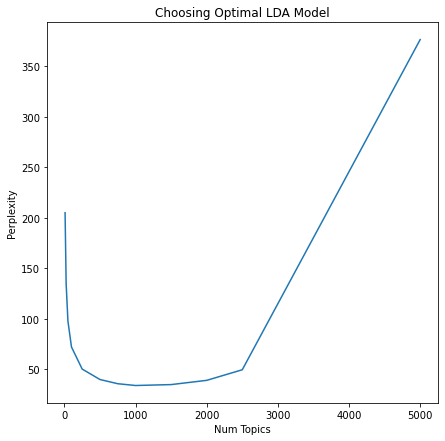

In [92]:
plt.figure(figsize=(7, 7))

plt.plot(n_components, perplexities)

plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Perplexity")
plt.savefig("optimal_model_perplexities.png")

---

In [80]:
import time
from datetime import timedelta, datetime

print(str(timedelta(seconds=time.time()+7200)).split(", ")[1])
start = datetime.now()

n_components = [10, 50, 100, 250, 500, 1000]
decays = [0.6, 0.7, 0.8, 0.9, 1.0]
learning_methods = ['batch', 'online']
models = {}
for n in n_components:
    for method in learning_methods:
        if method == 'online':
            for decay in decays:
                model = LatentDirichletAllocation(n_components=n, learning_method=method, learning_decay=decay, random_state=0)
                model.fit(data)
                print(f"Model with {n} topics, online learning method and {decay} learning decay fitted at {str(timedelta(seconds=time.time()+7200)).split(', ')[1]}.")
                models[(n, decay)] = model
        else:
            model = LatentDirichletAllocation(n_components=n, learning_method=method, random_state=0)
            model.fit(data)
            print(f"Model with {n} topics and batch learning method fitted at {str(timedelta(seconds=time.time()+7200)).split(', ')[1]}.")
            models[(n, method)] = model
            
print(str(timedelta(seconds=time.time()+7200)).split(", ")[1])
print(datetime.now()-start)

1:22:48.121763
Model with 10 topics and batch learning method fitted at 1:24:49.628628.
Model with 10 topics, online learning method and 0.6 learning decay fitted at 1:26:09.109533.
Model with 10 topics, online learning method and 0.7 learning decay fitted at 1:27:43.020087.
Model with 10 topics, online learning method and 0.8 learning decay fitted at 1:29:35.566701.
Model with 10 topics, online learning method and 0.9 learning decay fitted at 1:31:30.000870.
Model with 10 topics, online learning method and 1.0 learning decay fitted at 1:33:23.061644.
Model with 50 topics and batch learning method fitted at 1:35:40.491344.
Model with 50 topics, online learning method and 0.6 learning decay fitted at 1:37:56.198461.
Model with 50 topics, online learning method and 0.7 learning decay fitted at 1:40:06.490007.
Model with 50 topics, online learning method and 0.8 learning decay fitted at 1:42:29.356579.
Model with 50 topics, online learning method and 0.9 learning decay fitted at 1:44:54.7

KeyboardInterrupt: 

In [81]:
from collections import defaultdict

scores_by_decays = defaultdict(list)
topics_by_decays = defaultdict(list)

print(str(timedelta(seconds=time.time()+7200)).split(", ")[1])
start = datetime.now()

for n, decay in models.keys():
    #if decay != 'batch':
    model = models[(n, decay)]
    scores_by_decays[decay].append(model.score(data))
    print(f"Model with {n} topics and {decay} (decay) score found at {str(timedelta(seconds=time.time()+7200)).split(', ')[1]}.")
    topics_by_decays[decay].append(n)
    
print(str(timedelta(seconds=time.time()+7200)).split(", ")[1])
print(datetime.now()-start)

3:52:11.201377
Model with 10 topics and batch (decay) score found at 3:52:22.709274.
Model with 10 topics and 0.6 (decay) score found at 3:52:37.695731.
Model with 10 topics and 0.7 (decay) score found at 3:52:52.756420.
Model with 10 topics and 0.8 (decay) score found at 3:53:07.385339.
Model with 10 topics and 0.9 (decay) score found at 3:53:18.585938.
Model with 10 topics and 1.0 (decay) score found at 3:53:29.873676.
Model with 50 topics and batch (decay) score found at 3:53:42.925274.
Model with 50 topics and 0.6 (decay) score found at 3:53:54.851285.
Model with 50 topics and 0.7 (decay) score found at 3:54:06.687941.
Model with 50 topics and 0.8 (decay) score found at 3:54:19.301632.
Model with 50 topics and 0.9 (decay) score found at 3:54:31.030507.
Model with 50 topics and 1.0 (decay) score found at 3:54:42.909852.
Model with 100 topics and batch (decay) score found at 3:54:56.530761.
Model with 100 topics and 0.6 (decay) score found at 3:55:08.559363.
Model with 100 topics and

In [82]:
from matplotlib import pyplot as plt

batch
0.6
0.7
0.8
0.9
1.0


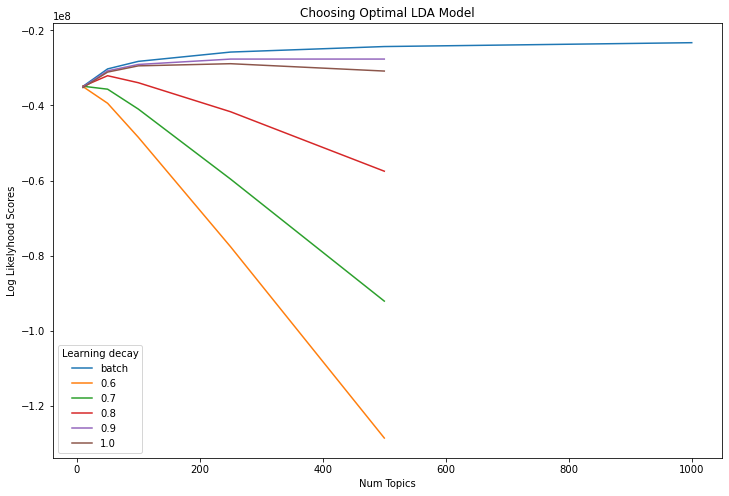

In [83]:
plt.figure(figsize=(12, 8))

for decay in scores_by_decays:
    print(decay)
    scores = scores_by_decays[decay]
    topics = topics_by_decays[decay]
    plt.plot(topics, scores, label=str(decay))

plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning decay', loc='best')
plt.savefig("optimal_model.png")

In [84]:
model = LatentDirichletAllocation(n_components=500, random_state=0)

In [85]:
results = model.fit_transform(data)

In [86]:
topics2 = {}
for i in range(500):
    topics2[i] = []

for i, prob in enumerate(results):
    topics2[np.argmax(prob)].append(data.index[i])

In [88]:
kuud = ['jaanuar', 'veebruar', 'märts', 'aprill', 'mai', 'juuni', 'juuli', 'august', 'mai', 'juuni', 'september', 'oktoober', 'november', 'detsember']
idx = []

for kuu in kuud:
    for topic, words in topics2.items():
        if kuu in words:
            idx.append(topic)
            continue

In [89]:
idx

[210, 210, 210, 210, 458, 278, 210, 181, 458, 278, 189, 189, 189, 189]

In [91]:
for i in set(idx):
    print(i, ":", topics2[i])
    print("----------------------------")

458 : ['kivipõrand', 'talvekuu', 'õu', 'front', 'dushsh', 'peletamine', 'judin', 'kali', 'tomatisupp', 'higi', 'talv', 'talvehommik', 'sõda', 'talveilm', 'kompress', 'talveöö', 'dušš', 'suplus', 'talveõhtu', 'tali', 'kõrgrõhkkond', 'mai', 'tuumasüntees', 'kõrgrõhuala', 'närv']
----------------------------
210 : ['eelarve', 'riigieksam', 'võrgusilm', 'jaanuar', 'käibeprognoos', 'kasumiprognoos', 'läbimõõt', 'kartulisaak', 'MK-sari', 'suvelavastus', 'tootmisplaan', 'erastamisprogramm', 'õllesummer', 'aprill', 'põhihooaeg', 'draft', 'säästueelarve', 'majanduskasvuprognoos', 'põhieelarve', 'veebruar', 'Oscari-gala', 'jazzkaar', 'abiturient', 'teatripreemia', 'suverull', 'lauluvõistlus', 'komeet', 'riigieelarve', 'MK-võistlus', 'juuli', 'avastart', 'jõulupuu', 'põhiturniir', 'märts', 'eurolugu', 'koolilõpetaja', 'orkaanihooaeg', 'peaesineja', 'linnaeelarve', 'playoff', 'sisehooaeg', 'iseseisvuspäev', 'eurolaul', 'võidupüha', 'MM-sari', 'rahupreemia', 'eurovisioon', 'laureaat', 'vanalinnapäe